In [3]:
#!/usr/bin/env python
import os.path, math, string, sys

import scurve
from scurve import progress, utils, draw
from PIL import Image, ImageDraw

import pandas as pd
import imageio.v3 as iio

## Functions and Classes definition

In [2]:
class _Color:
    def __init__(self, data, block):
        self.data, self.block = data, block
        s = list(set(data))
        s.sort()
        self.symbol_map = {v : i for (i, v) in enumerate(s)}

    def __len__(self):
        return len(self.data)

    def point(self, x):
        if self.block and (self.block[0]<=x<self.block[1]):
            return self.block[2]
        else:
            return self.getPoint(x)


class ColorGradient(_Color):
    def getPoint(self, x):
        c = ord(self.data[x])/255.0
        return [
            int(255*c),
            int(255*c),
            int(255*c)
        ]


class ColorHilbert(_Color):
    def __init__(self, data, block):
        _Color.__init__(self, data, block)
        self.csource = scurve.fromSize("hilbert", 3, 256**3)
        self.step = len(self.csource)/float(len(self.symbol_map))

    def getPoint(self, x):
        c = self.symbol_map[self.data[x]]
        return self.csource.point(int(c*self.step))


class ColorClass(_Color):
    def getPoint(self, x):
        c = ord(self.data[x])
        if c == 0:
            return [0, 0, 0]
        elif c == 255:
            return [255, 255, 255]
        elif chr(c) in string.printable:
            return [55, 126, 184]
        return [228, 26, 28]


class ColorEntropy(_Color):
    def getPoint(self, x):
        e = utils.entropy(self.data, 32, x, len(self.symbol_map))
        # http://www.wolframalpha.com/input/?i=plot+%284%28x-0.5%29-4%28x-0.5%29**2%29**4+from+0.5+to+1
        def curve(v):
            f = (4*v - 4*v**2)**4
            f = max(f, 0)
            return f
        r = curve(e-0.5) if e > 0.5 else 0
        b = e**2
        return [
            int(255*r),
            0,
            int(255*b)
        ]


def drawmap_unrolled(map, size, csource, name, prog):
    prog.set_target((size**2)*4)
    map = scurve.fromSize(map, 2, size**2)
    c = Image.new("RGB", (size, size*4))
    cd = ImageDraw.Draw(c)
    step = len(csource)/float(len(map)*4)
    sofar = 0
    for quad in range(4):
        for i, p in enumerate(map):
            off = (i + (quad * size**2))
            color = csource.point(
                        int(off * step)
                    )
            x, y = tuple(p)
            cd.point(
                (x, y + (size * quad)),
                fill=tuple(color)
            )
            if not sofar%100:
                prog.tick(sofar)
            sofar += 1
    c.save(name)


def drawmap_square(map, size, csource, name, prog):
    prog.set_target((size**2))
    map = scurve.fromSize(map, 2, size**2)
    c = Image.new("RGB", map.dimensions())
    cd = ImageDraw.Draw(c)
    step = len(csource)/float(len(map))
    for i, p in enumerate(map):
        color = csource.point(int(i*step))
        cd.point(tuple(p), fill=tuple(color))
        if not i%100:
            prog.tick(i)
    c.save(name)


def main():
    from optparse import OptionParser, OptionGroup
    parser = OptionParser(
                usage = "%prog [options] infile [output]",
                version="%prog 0.1",
            )
    parser.add_option(
        "-b", "--block", action="store",
        dest="block", default=None,
        help="Mark a block of data with a specified color. Format: hexstartaddr:hexendaddr[:hexcolor]"
    )
    parser.add_option(
        "-c", "--color", action="store",
        type="choice", dest="color", default="class",
        choices=["class", "hilbert", "entropy", "gradient"],
        help="Color map."
    )
    parser.add_option(
        "-m", "--map", action="store",
        type="choice", dest="map", default="hilbert",
        choices=sorted(scurve.curveMap.keys()),
        help="Pixel layout map. Can be any supported curve."
    )
    parser.add_option(
        "-n", "--namesuffix", action="store",
        type="str", dest="suffix", default="",
        help="Suffix for generated file names. Ignored if destination is specified."
    )
    parser.add_option(
        "-p", "--progress", action="store_true", default=False,
        dest="progress",
        help="Don't show progress bar - print the destination file name."
    )
    parser.add_option(
        "-s", "--size", action="store",
        type="int", dest="size", default=256,
        help="Image width in pixels."
    )
    parser.add_option(
        "-t", "--type", type="choice",
        dest="type", default="unrolled",
        choices=["unrolled", "square"],
        help="Image aspect ratio - square (1x1) or unrolled (1x4)"
    )
    parser.add_option(
        "-q", "--quiet", action="store_true",
        dest="quiet", default=False
    )
    options, args = parser.parse_args()
    if len(args) not in [1, 2]:
        parser.error("Please specify input and output file.")

    d = open(args[0], 'r').read() #Gets the input file path
    if len(args) == 2: #If input file path and output file path is provided => dest = output file path
        dst = args[1]
    else:
        base = os.path.basename(args[0]) #If not, output file = basename(input_file).suffix(default = "").png
        if "." in base:
            base, _ = base.rsplit(".", 1)
        dst = base + options.suffix + ".png"

    if os.path.exists(dst) and len(args) < 2: #If file with the output name exists, verify if the user wants to override it 
        print("Refusing to over-write '%s'. Specify explicitly if you really want to do this."%dst, file=sys.stderr)
        sys.exit(1)

    block = None#Not needed
    if options.block:
        parts = options.block.split(":")
        if len(parts) not in [2, 3]:
            raise ValueError("Invalid block specification.")
        s, e = int(parts[0], 16), int(parts[1], 16)
        if len(parts) == 3:
            c = draw.parseColor(parts[2])
        else:
            c = [255, 0, 0]
        block = (s, e, c)

    if options.color == "class":
        csource = ColorClass(d, block)
    elif options.color == "hilbert":
        csource = ColorHilbert(d, block)
    elif options.color == "gradient":
        csource = ColorGradient(d, block)
    else:
        csource = ColorEntropy(d, block)


    if options.progress:
        print(dst)

    if options.quiet or options.progress:
        prog = progress.Dummy()
    else:
        prog = progress.Progress(None)


    if options.type == "unrolled":
        drawmap_unrolled(options.map, options.size, csource, dst, prog)
    elif options.type == "square":
        drawmap_square(options.map, options.size, csource, dst, prog)
    prog.clear()

### Remove html files that are not utf-8 encoded

In [31]:
# import required module
import os

# assign directory
training_phishing_directory = "/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Phish/" #Dir with the phishing websites source codes
training_legitimate_directory = "/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/notPhish/" #Dir with the legitimate websites source codes

def try_utf8(data):
    "Returns a Unicode object on success, or None on failure"
    try:
       return data.decode('utf-8')
    except UnicodeDecodeError:
       return None

def remove_non_utf8(phish = True):
    if phish:
        for filename in listdir_nohidden(training_phishing_directory):
            file = open(training_phishing_directory + filename, 'rb')
            data = file.read()
            udata = try_utf8(data)
            if udata is None:
                os.remove(training_phishing_directory + filename) #removes a file.
            else:
                continue
            file.close()
    else:
        for filename in listdir_nohidden(training_legitimate_directory):
            file = open(training_legitimate_directory + filename, 'rb')
            data = file.read()
            udata = try_utf8(data)
            if udata is None:
                os.remove(training_legitimate_directory + filename) #removes a file.
            else:
                continue
            file.close()

In [32]:
remove_non_utf8() #For phishing websites
remove_non_utf8(False) #For legitimate websites

## Pipeline

In [169]:
import pandas as pd
import time

#For training

training_phishing = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Phish/' #Dir with the phishing websites
training_legitimate = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/NotPhish/' #Dir with the legitimate websites


bin_img_phish = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Binary_images/Phish/'#Dir to save images generated for phishing websites
bin_img_notphish = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Binary_images/NotPhish/'#Dir to save images generated for legitimate websites


n_samples = 250 #Number of samples per category(250 for phishing, 250 for legitimate)

def listdir_nohidden(path): #Lists all non hidden files
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

def innit_df(n_samples): #function that returns the data set according to the number of samples of each category wanted.
    isPhish = pd.DataFrame(data = {'File': list(listdir_nohidden(training_phishing)), 'BinaryImage': None, 'Phishing': 1 }) #Defines phish df and places all file names in File column
    notPhish = pd.DataFrame(data = {'File': list(listdir_nohidden(training_legitimate)), 'BinaryImage': None, 'Phishing': 0}) #Defines legitimate df and places all file names in File column
    
    sample_phish = isPhish.sample(n_samples) #Selects n_samples random rows from each df
    sample_legitimate = notPhish.sample(n_samples)
    
    final_df = (pd.concat([sample_phish, sample_legitimate], ignore_index = True)).sample(frac = 1).reset_index(drop = True) #returns a df with n_samples * 2 random rows made from the sample df's collected before
    final_df.Phishing = (final_df.Phishing).astype('category') #Set target column type to category
    
    return final_df #returns the dataframe

args = {'mapp': "hilbert", #Sets the static arguments
        'size': 128,
        'block': None,
        'prog': progress.Dummy()
        }

def generate_images(df, mapp, size, block ,prog): #Generates the images for the websites that are in the training dataframe
    aux_l = []
    for file in df.values:
        if(file[2] == 1):
            csource = ColorHilbert(open(training_phishing + file[0], 'r').read(), block)
            dst = bin_img_phish + file[0][:-5] + ".png"
        else:
            csource = ColorHilbert(open(training_legitimate + file[0], 'r').read(), block)
            dst = bin_img_notphish + file[0][:-5] + ".png"
        drawmap_unrolled(mapp, size, csource, dst, prog)
        aux_l.append(file[0][:-5] + ".png")
    df.BinaryImage = aux_l

In [72]:
df = innit_df(n_samples)
df

,File,BinaryImage,Phishing
0,7457919.html,None,1
1,7457287.html,None,1
2,7459114.html,None,1
3,6_dailysignal_com.html,None,0
4,6_unipi_it.html,None,0
...,...,...,...
495,7469545.html,None,1
496,7459548.html,None,1
497,7455445.html,None,1
498,7459582.html,None,1


In [ ]:
import datetime

start_time = time.time()

generate_images(df, args['mapp'], args['size'], args['block'], args['prog'])

timee = (time.time() - start_time)
print("--- Time: %s ---" %str(datetime.timedelta(seconds=round(timee))))
#--- Time: 0:44:36 ---

df.to_csv('/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/BinVis_DF.csv', index = False)

## Modeling

### Getting images matrixes

In [149]:
#Read the df
df = pd.read_csv('/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/BinVis_DF.csv')

In [151]:
#Add matrixes of each image to the dataframe
binary_images_path = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Binary_images/' #Dir to save images generated for phishing websites

bin_img_matx = []
for img in list(df.BinaryImage): #Get matrixes for each Binary Image
    bin_img_matx.append(iio.imread(binary_images_path + img)/255) #Normalize the values and append matrixes to a list and  
    
df['Matrixes_img'] = bin_img_matx #Assign matrixes to df column
cols = ['File', 'BinaryImage', 'Matrixes_img' ,'Phishing'] #Reorder dataframe
df = df[cols]

df.to_csv('/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/BinVis_DF_Final_Trian.csv', index = False)

In [154]:
df.head()

,File,BinaryImage,Matrixes_img,Phishing
0,7457919.html,7457919.png,"[[[0.5882352941176471, 0.8823529411764706, 0.2...",1
1,7457287.html,7457287.png,"[[[0.5882352941176471, 0.6823529411764706, 0.0...",1
2,7459114.html,7459114.png,"[[[0.807843137254902, 0.5529411764705883, 0.16...",1
3,6_dailysignal_com.html,6_dailysignal_com.png,"[[[0.5333333333333333, 0.5529411764705883, 0.1...",0
4,6_unipi_it.html,6_unipi_it.png,"[[[0.5333333333333333, 0.5529411764705883, 0.1...",0


In [155]:
IMAGE_SHAPE = 

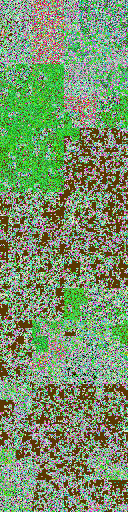

In [172]:
Image.open("/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Binary_images/NotPhish/0_canlidoviz_com.png")

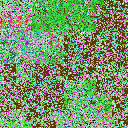

In [180]:
c

In [196]:
map = "hilbert"
size = 128
block = None
prog = progress.Progress(None)
d = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/Phish/7454432.html'
csource = ColorHilbert(open(d, 'r').read(), block)
base = os.path.basename(d)
if "." in base:
    base, _ = base.rsplit(".", 1)
dst = base + "" + ".png"


|---------------------------------------> | 0:00:00

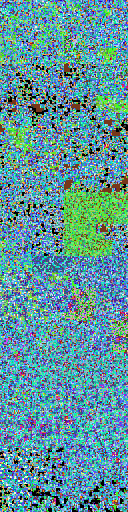

In [186]:
#drawmap_square(map, size, csource, name, prog):
prog.set_target((size**2)*4)
map = scurve.fromSize(map, 2, size**2)
c = Image.new("RGB", (size, size*4))
cd = ImageDraw.Draw(c)
step = len(csource)/float(len(map)*4)
sofar = 0
for quad in range(4):
    for i, p in enumerate(map):
        off = (i + (quad * size**2))
        color = csource.point(
                    int(off * step)
                )
        x, y = tuple(p)
        cd.point(
            (x, y + (size * quad)),
            fill=tuple(color)
        )
        if not sofar%100:
            prog.tick(sofar)
        sofar += 1
c

|---------------------------------------> | 0:00:00

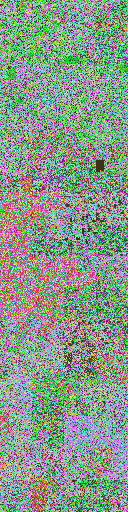

In [197]:
g = '/Users/joao.ferreira/Documents/Anaconda-jupyter/archive/training/NotPhish/4_www_facebook_com_ripplepay_.html'
csource = ColorHilbert(open(g, 'r').read(), block)
prog.set_target((size**2)*4)
map = scurve.fromSize(map, 2, size**2)
ç = Image.new("RGB", (size, size*4))
cd = ImageDraw.Draw(ç)
step = len(csource)/float(len(map)*4)
sofar = 0
for quad in range(4):
    for i, p in enumerate(map):
        off = (i + (quad * size**2))
        color = csource.point(
                    int(off * step)
                )
        x, y = tuple(p)
        cd.point(
            (x, y + (size * quad)),
            fill=tuple(color)
        )
        if not sofar%100:
            prog.tick(sofar)
        sofar += 1
ç

In [195]:
del map